In [115]:
#------Importing Libraries------#
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import classification_report, mean_squared_error

In [116]:
#---------Data loading and preprocessing---------#

# Load the data
data = pd.read_csv('proj-data.csv')

# Data preprocessing
# Remove trailing colons from column names
data.columns = data.columns.str.rstrip(':').str.strip()

# Replace non-numeric values with NaN
data.replace('?', np.nan, inplace=True)

# Handle binary columns
binary_columns = ['TSH measured', 'T3 measured', 'TT4 measured', 'T4U measured', 'FTI measured', 'TBG measured']
for col in binary_columns:
    data[col] = data[col].map({'f': 0, 't': 1})

# Convert appropriate columns to numeric
numeric_columns = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG']
for col in numeric_columns:
    data[col] = pd.to_numeric(data[col], errors='coerce')

# Check for negative values before imputation
print("Negative values before imputation in age:", (data['age'] < 0).sum())

# Handle missing values for numeric columns
imputer = SimpleImputer(strategy='mean')
data[numeric_columns] = imputer.fit_transform(data[numeric_columns])

# Check for negative values after imputation
print("Negative values after imputation in age:", (data['age'] < 0).sum())

# Encode categorical variables
label_encoders = {}
categorical_columns = ['sex', 'on thyroxine', 'query on thyroxine', 'on antithyroid medication', 'sick', 'pregnant',
                       'thyroid surgery', 'I131 treatment', 'query hypothyroid', 'query hyperthyroid', 'lithium', 
                       'goitre', 'tumor', 'hypopituitary', 'psych', 'referral source', 'diagnoses']
for column in categorical_columns:
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column].astype(str))

# Preserve the record identification column
record_identification = data['[record identification]'].values

# Drop the record identification column from the main DataFrame
data.drop(columns=['[record identification]'], inplace=True)

Negative values before imputation in age: 0
Negative values after imputation in age: 0


In [117]:
#--------Debugging--------#

# Ensure all data is numeric
#print(data.dtypes)

# Check for non-numeric data in the dataset
for col in data.columns:
    if data[col].dtype == 'object':
        print(f"Column {col} contains non-numeric values.")
        print(data[col].unique())

In [118]:
#----------Label Encoding and mapping----------#

# Define the mapping for new classes
diagnosis_mapping = {
    '-': 'healthy',
    'A': 'hyperthyroid conditions', 'B': 'hyperthyroid conditions', 'C': 'hyperthyroid conditions', 'D': 'hyperthyroid conditions',
    'E': 'hypothyroid conditions', 'F': 'hypothyroid conditions', 'G': 'hypothyroid conditions', 'H': 'hypothyroid conditions',
    'I': 'binding protein', 'J': 'binding protein',
    'K': 'general health',
    'L': 'replacement therapy', 'M': 'replacement therapy', 'N': 'replacement therapy',
    'R': 'discordant results'
}

# Add remaining classes to 'other'
original_diagnoses_labels = label_encoders['diagnoses'].classes_
for label in original_diagnoses_labels:
    if label not in diagnosis_mapping:
        diagnosis_mapping[label] = 'other'

# Map the diagnoses to new classes
data['diagnoses'] = data['diagnoses'].map(lambda x: diagnosis_mapping[label_encoders['diagnoses'].inverse_transform([x])[0]])

# Encode the new class labels
label_encoders['diagnoses'] = LabelEncoder()
data['diagnoses'] = label_encoders['diagnoses'].fit_transform(data['diagnoses'])

In [136]:
#--------Diagnose prediction model--------#

X_diagnosis = data.drop(['diagnoses'], axis=1)
y_diagnosis = data['diagnoses']

# Split data into training and testing sets for diagnosis prediction
X_train_diag, X_test_diag, y_train_diag, y_test_diag = train_test_split(X_diagnosis, y_diagnosis, test_size=0.2, random_state=42)

# Model training for diagnosis prediction
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train_diag, y_train_diag)

# Model evaluation for diagnosis prediction
y_pred_diag = dt_classifier.predict(X_test_diag)

# Retrieve original class labels for diagnoses
new_diagnoses_labels = label_encoders['diagnoses'].classes_

# Print class labels and their corresponding diagnoses
for class_label, diagnosis in enumerate(new_diagnoses_labels):
    print(f"Class {class_label}: {diagnosis}")

print(classification_report(y_test_diag, y_pred_diag, target_names=new_diagnoses_labels))

# Create a DataFrame to display the results with record identification
predictions_df = pd.DataFrame({'Actual diagnose': y_test_diag, 'Predicted diagnose': y_pred_diag})
print(predictions_df)
print('MSE:', mean_squared_error(y_test_diag, y_pred_diag))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_diag, y_pred_diag))
print('RMSE:', rmse)

# Feature importance for diagnosis prediction
importances_diag = dt_classifier.feature_importances_
feature_importance_dt_diag = pd.DataFrame({'Feature': X_diagnosis.columns, 'Importance': importances_diag})
print(feature_importance_dt_diag.sort_values(by='Importance', ascending=False))

Class 0: binding protein
Class 1: discordant results
Class 2: general health
Class 3: healthy
Class 4: hyperthyroid conditions
Class 5: hypothyroid conditions
Class 6: other
Class 7: replacement therapy
                         precision    recall  f1-score   support

        binding protein       0.80      0.75      0.77        55
     discordant results       0.75      0.68      0.71        31
         general health       0.93      0.94      0.94        72
                healthy       0.97      0.97      0.97      1114
hyperthyroid conditions       0.76      0.76      0.76        25
 hypothyroid conditions       0.94      0.98      0.96        81
                  other       0.82      0.85      0.84        33
    replacement therapy       0.93      0.91      0.92        57

               accuracy                           0.95      1468
              macro avg       0.86      0.85      0.86      1468
           weighted avg       0.95      0.95      0.95      1468

      Actual d

0       29.0
1       29.0
2       36.0
3       60.0
4       77.0
        ... 
7333    56.0
7334    22.0
7335    69.0
7336    47.0
7337    31.0
Name: age, Length: 7338, dtype: float64
Negative X_age: 0
Negative predicted ages: 0
     Record Identification  Actual Age  Predicted Age
996            [841122082]        34.0      62.676873
736            [850912062]        58.0      53.370000
1244           [841127060]        41.0      35.820000
1181           [840823010]        28.0      65.290000
3393           [861121057]        24.0      49.690000
...                    ...         ...            ...
705            [850423010]        72.0      39.530000
5219           [860210066]        79.0      53.850000
5407           [861119045]        77.0      58.280000
4267           [850801049]        69.0      55.305000
57             [840903010]        69.0      41.510000

[1468 rows x 3 columns]
MSE: 3132754.894440425
RMSE: 1769.9590092542892
                      Feature  Importance
22       

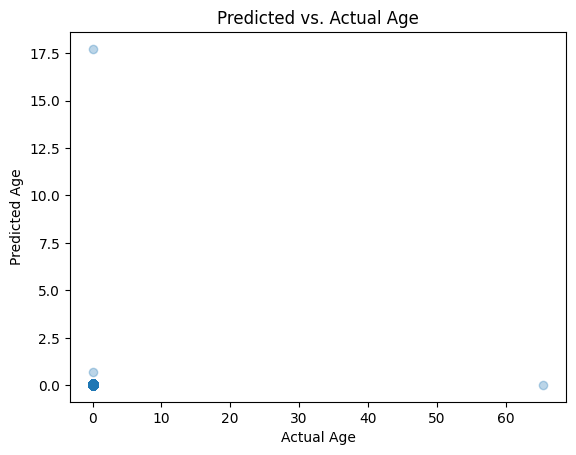

In [134]:
#---------Age prediction model---------#

from sklearn.ensemble import RandomForestRegressor


X_age = data.drop(['age'], axis=1)
y_age = data['age']

print(y_age)
# Split data into training and testing sets for age prediction
X_train_age, X_test_age, y_train_age, y_test_age, record_train, record_test = train_test_split(X_age, y_age, record_identification, test_size=0.2, random_state=42)

# Apply feature scaling
scaler = StandardScaler()
X_train_age = scaler.fit_transform(X_train_age)
X_test_age = scaler.transform(X_test_age)

# Model training for age prediction
gbr_regressor = RandomForestRegressor()
gbr_regressor.fit(X_train_age, y_train_age)
print("Negative X_age:", (gbr_regressor.predict(X_test_age) < 0).sum())
# Age prediction evaluation
y_pred_age = gbr_regressor.predict(X_test_age)

# Check for negative predicted ages
print("Negative predicted ages:", (y_pred_age < 0).sum())


# Create a DataFrame to display the results with record identification
predictions_df = pd.DataFrame({'Record Identification': record_test, 'Actual Age': y_test_age, 'Predicted Age': y_pred_age})
print(predictions_df)
print('MSE:', mean_squared_error(y_test_age, y_pred_age))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_age, y_pred_age))
print('RMSE:', rmse)

# Feature importance for age prediction
importances_age = gbr_regressor.feature_importances_
feature_importance_rf_age = pd.DataFrame({'Feature': X_age.columns, 'Importance': importances_age})
print(feature_importance_rf_age.sort_values(by='Importance', ascending=False))

# Plot predicted vs. actual ages
plt.scatter(y_test_age/1000, y_pred_age/1000, alpha=0.3)
plt.xlabel('Actual Age')
plt.ylabel('Predicted Age')
plt.title('Predicted vs. Actual Age')
plt.show()

In [137]:
#---------Sex prediction model---------#

# Gender prediction model
X_gender = data.drop(['sex'], axis=1)
y_gender = data['sex']

# Split data into training and testing
X_train_gender, X_test_gender, y_train_gender, y_test_gender, record_train, record_test = train_test_split(X_gender, y_gender, record_identification, test_size=0.2, random_state=42)

# Model training
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_gender, y_train_gender)

y_pred_gender = rf_classifier.predict(X_test_gender)

predictions2_df = pd.DataFrame({'Record Identification': record_test, 'Actual gender': y_test_gender, 'Predicted sex': y_pred_gender})
print(predictions2_df)

# Feature importance for sex prediction
importances_gender = rf_classifier.feature_importances_
feature_importance_rf_gender = pd.DataFrame({'Feature': X_gender.columns, 'Importance': importances_gender})
print(feature_importance_rf_gender.sort_values(by='Importance', ascending=False))

#accuracy = accuracy_score(y_test_gender, y_pred_gender)
#print('Accuracy:', accuracy)

print(classification_report(y_test_gender, y_pred_gender, target_names=label_encoders['sex'].classes_))

# Create a DataFrame to display the results with record identification
predictions_df = pd.DataFrame({'Record Identification': record_test, 'Actual gender': y_test_gender, 'Predicted gender': y_pred_gender})
print(predictions_df)
print('MSE:', mean_squared_error(y_test_gender, y_pred_gender))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test_gender, y_pred_gender))
print('RMSE:', rmse)

     Record Identification  Actual gender  Predicted sex
996            [841122082]              0              0
736            [850912062]              1              0
1244           [841127060]              0              0
1181           [840823010]              0              0
3393           [861121057]              0              0
...                    ...            ...            ...
705            [850423010]              1              0
5219           [860210066]              0              0
5407           [861119045]              0              0
4267           [850801049]              0              0
57             [840903010]              0              1

[1468 rows x 3 columns]
                      Feature  Importance
0                         age    0.149877
22                        T4U    0.146886
20                        TT4    0.139814
16                        TSH    0.134597
24                        FTI    0.128437
18                         T3    0.1010